# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [2]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [3]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [4]:
#used smaller sample so it could run on my laptop
N_Train=400000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


In [5]:
print(X_Train.shape)
print(y_Train.shape)

(400000, 18)
(400000,)


We can train the classifier as follow:

In [6]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

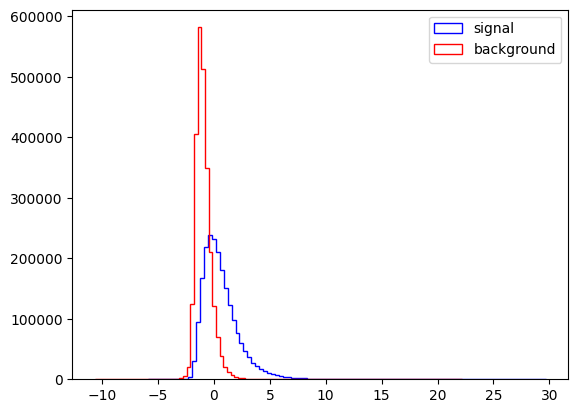

In [8]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

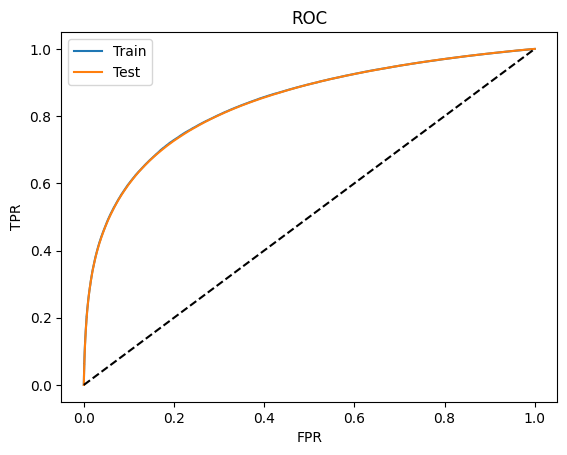

In [7]:
from sklearn.metrics import roc_curve, auc

y_Train_score = Fisher.decision_function(X_Train)
y_Test_score = Fisher.decision_function(X_Test)
fpr_train, tpr_train, _ = roc_curve(y_Train, y_Train_score)
fpr_test, tpr_test, _ = roc_curve(y_Test, y_Test_score)
plt.plot(fpr_train, tpr_train, label="Train")
plt.plot(fpr_test, tpr_test, label="Test")
plt.plot([0,1], [0,1], 'k--')  # Random guessing line
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()
plt.show()

#There is no visible bias from the plot

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

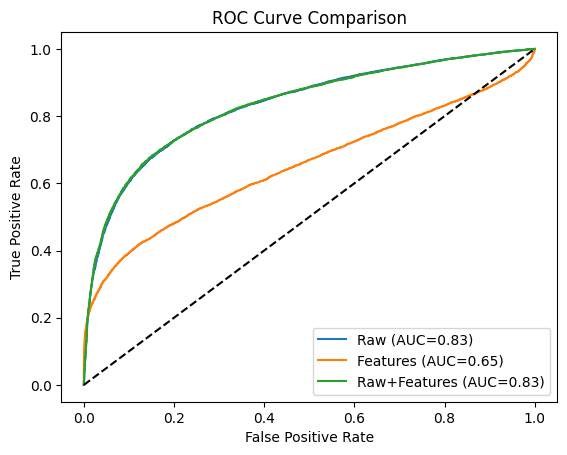

In [9]:
import gc  # garbage collector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

use_cols = ["signal", "l_1_pT", "l_1_eta", "MET", "MET_phi", 
            "MET_rel", "axial_MET", "R", "MT2"]
df = pd.read_csv(filename, dtype='float64', names=VarNames, usecols=use_cols)

# made a smaller sample so it could run on my laptop
Train_Sample = df[:N_Train].sample(20000, random_state=42)
Test_Sample = df[N_Train:N_Train+20000]
y_train = Train_Sample["signal"].values
y_test = Test_Sample["signal"].values
results = []

raw_vars = ["l_1_pT", "l_1_eta", "MET", "MET_phi"]
X_train_raw = Train_Sample[raw_vars].values
X_test_raw = Test_Sample[raw_vars].values

model = LDA(solver='svd')
model.fit(X_train_raw, y_train)
scores = model.decision_function(X_test_raw)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)
results.append( ("Raw", fpr, tpr, roc_auc) )
del model, X_train_raw, X_test_raw, scores
gc.collect()

feat_vars = ["MET_rel", "axial_MET", "R", "MT2"]
X_train_feat = Train_Sample[feat_vars].values
X_test_feat = Test_Sample[feat_vars].values
model = LDA(solver='svd')
model.fit(X_train_feat, y_train)
scores = model.decision_function(X_test_feat)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)
results.append( ("Features", fpr, tpr, roc_auc) )
del model, X_train_feat, X_test_feat, scores
gc.collect()

all_vars = raw_vars + feat_vars
X_train_all = Train_Sample[all_vars].values
X_test_all = Test_Sample[all_vars].values
model = LDA(solver='svd')
model.fit(X_train_all, y_train)
scores = model.decision_function(X_test_all)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)
results.append( ("Raw+Features", fpr, tpr, roc_auc) )
del model, X_train_all, X_test_all, scores
gc.collect()

for label, fpr, tpr, roc_auc in results:
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [ ]:
#4a
#Logistic Regression , Linear Discriminant Analysis , Gaussian Naive Bayes

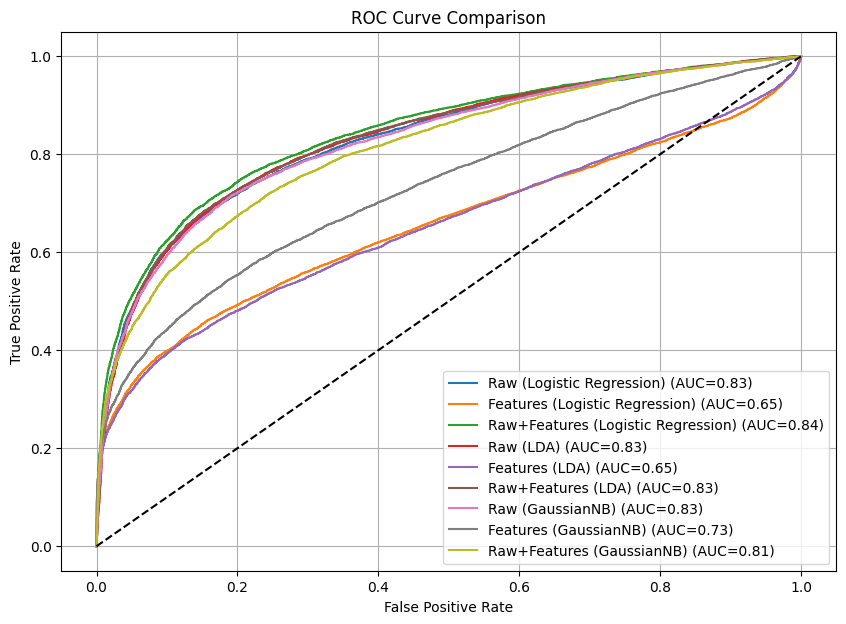

In [21]:
#4b
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB

Train_Sample = df[:N_Train].sample(20000, random_state=42)
Test_Sample = df[N_Train:N_Train+20000]
y_train = Train_Sample["signal"].values
y_test = Test_Sample["signal"].values
raw_vars = ["l_1_pT", "l_1_eta", "MET", "MET_phi"]
feat_vars = ["MET_rel", "axial_MET", "R", "MT2"]
all_vars = raw_vars + feat_vars

def evaluate_classifier(model, model_name):
    results = []

    X_train = Train_Sample[raw_vars].values
    X_test = Test_Sample[raw_vars].values
    model.fit(X_train, y_train)
    scores = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    results.append( (f"Raw ({model_name})", fpr, tpr, roc_auc) )
    del X_train, X_test, scores
    gc.collect()
    
    X_train = Train_Sample[feat_vars].values
    X_test = Test_Sample[feat_vars].values
    model.fit(X_train, y_train)
    scores = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    results.append( (f"Features ({model_name})", fpr, tpr, roc_auc) )
    del X_train, X_test, scores
    gc.collect()

    X_train = Train_Sample[all_vars].values
    X_test = Test_Sample[all_vars].values
    model.fit(X_train, y_train)
    scores = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    results.append( (f"Raw+Features ({model_name})", fpr, tpr, roc_auc) )
    del X_train, X_test, scores
    gc.collect()

    return results

all_results = []
clf1 = LogisticRegression(solver='lbfgs', max_iter=1000)
all_results += evaluate_classifier(clf1, "Logistic Regression")
clf2 = LDA(solver='svd')
all_results += evaluate_classifier(clf2, "LDA")
clf3 = GaussianNB()
all_results += evaluate_classifier(clf3, "GaussianNB")

plt.figure(figsize=(10, 7))
for label, fpr, tpr, roc_auc in all_results:
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#4c

X_train_all = Train_Sample[all_vars].values
X_test_all = Test_Sample[all_vars].values
best_model = LogisticRegression(solver='lbfgs', max_iter=1000)
best_model.fit(X_train_all, y_train)

scores = best_model.decision_function(X_test_all) if hasattr(best_model, "decision_function") else best_model.predict_proba(X_test_all)[:,1]
mask_signal = (y_test == 1)
mask_background = (y_test == 0)
sorted_scores = np.sort(scores)
sigmas = []

for threshold in sorted_scores:
    N_S = np.sum(scores[mask_signal] > threshold)
    N_B = np.sum(scores[mask_background] > threshold)
    if N_S + N_B > 0:
        sigma = N_S / np.sqrt(N_S + N_B)
        sigmas.append((threshold, sigma))
thresholds, sigma_values = zip(*sigmas)
max_sigma = sigma_values[best_idx]
print(f"Maximal significance (sigma_S): {max_sigma:.2f}")

Maximal significance (sigma_S): 72.70


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [20]:
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score)

X_train_all = Train_Sample[all_vars].values
X_test_all = Test_Sample[all_vars].values

best_model = LogisticRegression(solver='lbfgs', max_iter=1000)
best_model.fit(X_train_all, y_train)
scores = best_model.decision_function(X_test_all) if hasattr(best_model, "decision_function") else best_model.predict_proba(X_test_all)[:, 1]
mask_signal = (y_test == 1)
mask_background = (y_test == 0)
sorted_scores = np.sort(scores)
sigmas = []

for threshold in sorted_scores:
    N_S = np.sum(scores[mask_signal] > threshold)
    N_B = np.sum(scores[mask_background] > threshold)
    if N_S + N_B > 0:
        sigma = N_S / np.sqrt(N_S + N_B)
        sigmas.append((threshold, sigma))
thresholds, sigma_values = zip(*sigmas)
max_sigma = sigma_values[best_idx]

y_pred_best = (scores > best_threshold).astype(int)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)   # TPR at best threshold
f1 = f1_score(y_test, y_pred_best)
accuracy = accuracy_score(y_test, y_pred_best)
false_positive_rate = np.sum((y_test == 0) & (y_pred_best == 1)) / np.sum(y_test == 0)

results_table = pd.DataFrame({
    "Metric": ["Best Threshold","True Positive Rate (TPR)","False Positive Rate (FPR)","Area Under ROC (AUC)",
        "Precision","Recall","F1 Score","Accuracy","Maximal Significance (σ_S)"],
    "Value": [best_threshold,recall,false_positive_rate,roc_auc,precision,recall,f1,accuracy,max_sigma]
})

display(HTML(results_table.to_html(index=False)))


Metric,Value
Best Threshold,-0.539212
True Positive Rate (TPR),0.780035
False Positive Rate (FPR),0.245998
Area Under ROC (AUC),0.843755
Precision,0.732029
Recall,0.780035
F1 Score,0.755270
Accuracy,0.766050
Maximal Significance (σ_S),72.699710
